# NLP Pipeline using Clinical Notes

This Python script aims to develop a Natural Language Processing (NLP) pipeline.  

1. Data Preprocessing: Cleaning and preparing clinical notes for NLP analysis.
2. Feature Extraction: Identifying relevant features in the text that might signal sepsis.
3. Model Selection: Implementing suitable NLP models for sepsis detection.
4. Evaluation: Assessing the model's performance in identifying sepsis cases.

## Data Preprocessing

In this section, we will preprocess the clinical notes data to prepare it for NLP analysis. The preprocessing steps include:
1. Removing any irrelevant information.
2. Tokenizing the text.
3. Removing stop words.
4. Performing lemmatization to normalize the words.

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy
import torch
from tqdm import tqdm
from transformers import pipeline

# Set up the directory path
directory = os.getenv('CLINICAL_REFS_DIR', "./clinical_refs")

if not os.path.exists(directory):
    os.makedirs(directory)

# File paths
train_file_path = os.path.join(directory, 'MTS-Dialog-TrainingSet.csv')
validation_file_path = os.path.join(directory, 'MTS-Dialog-ValidationSet.csv')

# Load the datasets
train_df = pd.read_csv(train_file_path)
validation_df = pd.read_csv(validation_file_path)

# Explicitly retrieve headers
train_headers = train_df.columns.tolist()
validation_headers = validation_df.columns.tolist()

# Print the column headers to confirm the available columns
print("Training dataset columns:", train_headers)
print("Validation dataset columns:", validation_headers)

# Display the first few rows of each dataset
print("Training dataset preview:")
print(train_df.head())

print("Validation dataset preview:")
print(validation_df.head())

# Load spacy model with troubleshooting
try:
    nlp = spacy.load("en_core_web_sm")
    print("SpaCy model loaded successfully.")
except Exception as e:
    print(f"Error loading SpaCy model: {e}")
    print("Attempting to download the model...")
    try:
        import spacy.cli
        spacy.cli.download("en_core_web_sm")
        nlp = spacy.load("en_core_web_sm")
        print("SpaCy model downloaded and loaded successfully.")
    except Exception as download_error:
        print(f"Error downloading or loading SpaCy model: {download_error}")

# Set random seed for reproducibility
np.random.seed(42)


/usr/local/python/3.10.13/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training dataset columns: ['ID', 'section_header', 'section_text', 'dialogue']
Validation dataset columns: ['ID', 'section_header', 'section_text', 'dialogue']
Training dataset preview:
   ID section_header                                       section_text  \
0   0          GENHX  The patient is a 76-year-old white female who ...   
1   1          GENHX  The patient is a 25-year-old right-handed Cauc...   
2   2          GENHX  This is a 22-year-old female, who presented to...   
3   3    MEDICATIONS  Prescribed medications were Salmeterol inhaler...   
4   4             CC                                   Burn, right arm.   

                                            dialogue  
0  Doctor: What brings you back into the clinic t...  
1  Doctor: How're you feeling today?  \r\nPatient...  
2  Doctor: Hello, miss. What is the reason for yo...  
3  Doctor: Are you taking any over the counter me...  
4  Doctor: Hi, how are you? \r\nPatient: I burned...  
Validation dataset preview:
   ID

In [4]:
## DIAGNOSTIC CELL

# Verify if train_df and validation_df are defined
try:
    print("Checking train_df...")
    print(train_df.head())
    print("train_df is defined and accessible.")
except NameError as e:
    print(f"Error: train_df is not defined. {e}")

try:
    print("Checking validation_df...")
    print(validation_df.head())
    print("validation_df is defined and accessible.")
except NameError as e:
    print(f"Error: validation_df is not defined. {e}")


Checking train_df...
   ID section_header                                       section_text  \
0   0          GENHX  The patient is a 76-year-old white female who ...   
1   1          GENHX  The patient is a 25-year-old right-handed Cauc...   
2   2          GENHX  This is a 22-year-old female, who presented to...   
3   3    MEDICATIONS  Prescribed medications were Salmeterol inhaler...   
4   4             CC                                   Burn, right arm.   

                                            dialogue  
0  Doctor: What brings you back into the clinic t...  
1  Doctor: How're you feeling today?  \r\nPatient...  
2  Doctor: Hello, miss. What is the reason for yo...  
3  Doctor: Are you taking any over the counter me...  
4  Doctor: Hi, how are you? \r\nPatient: I burned...  
train_df is defined and accessible.
Checking validation_df...
   ID section_header                                       section_text  \
0   0          GENHX  The patient is a 26-year-old female, re

## Data Preprocessing

In this section, we will preprocess the clinical notes data to prepare it for NLP analysis. The preprocessing steps include:
1. Removing any irrelevant information.
2. Tokenizing the text.
3. Removing stop words.
4. Performing lemmatization to normalize the words.


In [10]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import logging
import spacy

# Configure logging
logging.basicConfig(level=logging.ERROR)

# Download necessary NLTK data files
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize the lemmatizer and stop words list
lemmatizer = WordNetLemmatizer()
default_stop_words = set(stopwords.words('english'))

# Add domain-specific stop words (extend this list as needed)
medical_stop_words = {'patient', 'doctor', 'mg', 'ml'}
stop_words = default_stop_words.union(medical_stop_words)

# Load spacy model for more robust tokenization and lemmatization
nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    """
    Preprocess the input text by:
    1. Lowercasing the text
    2. Removing non-alphanumeric characters
    3. Tokenizing the text
    4. Removing stop words
    5. Lemmatizing the words
    """
    try:
        # Lowercase the text
        text = text.lower()

        # Remove non-alphanumeric characters
        text = re.sub(r'\W', ' ', text)

        # Tokenize the text using Spacy
        doc = nlp(text)
        tokens = [token.lemma_ for token in doc if token.text not in stop_words and not token.is_punct and not token.is_space]

        # Join tokens back to a single string
        processed_text = ' '.join(tokens)

        return processed_text

    except Exception as e:
        logging.error(f"Error during text preprocessing: {e}")
        return ""

# Apply preprocessing to the training and validation datasets
train_df['processed_text'] = train_df['section_text'].apply(preprocess_text)
validation_df['processed_text'] = validation_df['section_text'].apply(preprocess_text)

# Display the first few rows of the processed training dataset
print("Processed Training DataFrame:")
print(train_df[['ID', 'section_text', 'processed_text']].head())

# Display the first few rows of the processed validation dataset
print("Processed Validation DataFrame:")
print(validation_df[['ID', 'section_text', 'processed_text']].head())


[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Processed Training DataFrame:
   ID                                       section_text  \
0   0  The patient is a 76-year-old white female who ...   
1   1  The patient is a 25-year-old right-handed Cauc...   
2   2  This is a 22-year-old female, who presented to...   
3   3  Prescribed medications were Salmeterol inhaler...   
4   4                                   Burn, right arm.   

                                      processed_text  
0  76 year old white female present clinic today ...  
1  25 year old right handed caucasian female pres...  
2  22 year old female present office complaining ...  
3  prescribe medication salmeterol inhaler prn fl...  
4                                     burn right arm  
Processed Validation DataFrame:
   ID                                       section_text  \
0   0  The patient is a 26-year-old female, referred ...   
1   1  As mentioned denies any oropharyngeal swelling...   
2   2  Essentially unchanged from her visit of 04/15/...   
3   3  

### Feature Extraction using BioBert

In [11]:
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
import logging

# Initialize BioBERT model and tokenizer from Hugging Face
model_name = "dmis-lab/biobert-base-cased-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

def embed_text(text, tokenizer, model):
    """
    Embed the input text using the BioBERT model.
    """
    try:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        # Use the embeddings of the [CLS] token
        cls_embedding = outputs.last_hidden_state[:, 0, :].numpy().flatten()
        return cls_embedding
    except Exception as e:
        logging.error(f"Error during text embedding: {e}")
        return np.zeros(model.config.hidden_size)

# Embed the processed text for the training and validation datasets
train_df['embedding'] = train_df['processed_text'].apply(lambda x: embed_text(x, tokenizer, model))
validation_df['embedding'] = validation_df['processed_text'].apply(lambda x: embed_text(x, tokenizer, model))

# Convert embeddings to a numpy array for clustering
X_train = np.vstack(train_df['embedding'].values)
X_validation = np.vstack(validation_df['embedding'].values)

# Display the shape of the extracted features
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_validation: {X_validation.shape}")


/usr/local/python/3.10.13/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Shape of X_train: (1201, 768)
Shape of X_validation: (100, 768)


### Model Selection and Training

In [12]:
from sklearn.cluster import KMeans
import logging

def apply_kmeans_clustering(X_train, X_validation, num_clusters=2):
    """
    Apply K-Means clustering to the training and validation sets.
    """
    try:
        # Initialize the K-Means model
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)

        # Fit the model to the training data
        kmeans.fit(X_train)

        # Predict clusters for the training and validation sets
        train_clusters = kmeans.predict(X_train)
        validation_clusters = kmeans.predict(X_validation)

        logging.info("K-Means clustering completed successfully.")
        return train_clusters, validation_clusters, kmeans

    except Exception as e:
        logging.error(f"Error during K-Means clustering: {e}")
        raise

# Apply K-Means clustering
try:
    num_clusters = 3  # Adjust the number of clusters as needed
    train_clusters, validation_clusters, kmeans = apply_kmeans_clustering(X_train, X_validation, num_clusters)

    # Add the cluster labels to the DataFrames for inspection
    train_df['cluster'] = train_clusters
    validation_df['cluster'] = validation_clusters

    # Display the cluster assignments
    print("Training DataFrame with cluster labels:")
    print(train_df[['ID', 'section_text', 'cluster']].head())

    print("Validation DataFrame with cluster labels:")
    print(validation_df[['ID', 'section_text', 'cluster']].head())

except Exception as e:
    logging.error(f"Error during K-Means clustering setup: {e}")


/usr/local/python/3.10.13/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training DataFrame with cluster labels:
   ID                                       section_text  cluster
0   0  The patient is a 76-year-old white female who ...        1
1   1  The patient is a 25-year-old right-handed Cauc...        1
2   2  This is a 22-year-old female, who presented to...        1
3   3  Prescribed medications were Salmeterol inhaler...        0
4   4                                   Burn, right arm.        0
Validation DataFrame with cluster labels:
   ID                                       section_text  cluster
0   0  The patient is a 26-year-old female, referred ...        1
1   1  As mentioned denies any oropharyngeal swelling...        1
2   2  Essentially unchanged from her visit of 04/15/...        0
3   3                                          Accutane.        2
4   4                      Confusion and hallucinations.        0


In [13]:
from collections import Counter

def analyze_clusters(df, num_clusters):
    """
    Analyze the clusters to identify sepsis-related content.
    """
    cluster_analysis = {}
    sepsis_keywords = ['sepsis', 'septic', 'infection', 'organ failure', 'blood culture', 'antibiotics']

    for cluster_id in range(num_clusters):
        cluster_texts = df[df['cluster'] == cluster_id]['processed_text'].tolist()
        word_counter = Counter(' '.join(cluster_texts).split())

        # Count the frequency of sepsis-related keywords
        sepsis_keyword_count = {keyword: word_counter[keyword] for keyword in sepsis_keywords}
        total_words = sum(word_counter.values())

        # Calculate the relative frequency of sepsis-related keywords
        relative_frequency = {keyword: count / total_words for keyword, count in sepsis_keyword_count.items()}

        cluster_analysis[cluster_id] = {
            'total_texts': len(cluster_texts),
            'sepsis_keyword_count': sepsis_keyword_count,
            'relative_frequency': relative_frequency
        }

    return cluster_analysis

# Analyze the clusters in the training DataFrame
num_clusters = 3
cluster_analysis = analyze_clusters(train_df, num_clusters)

# Display the analysis results
for cluster_id, analysis in cluster_analysis.items():
    print(f"\nCluster {cluster_id} Analysis:")
    print(f"Total texts: {analysis['total_texts']}")
    print("Sepsis Keyword Count:", analysis['sepsis_keyword_count'])
    print("Relative Frequency of Sepsis Keywords:", analysis['relative_frequency'])



Cluster 0 Analysis:
Total texts: 579
Sepsis Keyword Count: {'sepsis': 1, 'septic': 0, 'infection': 8, 'organ failure': 0, 'blood culture': 0, 'antibiotics': 0}
Relative Frequency of Sepsis Keywords: {'sepsis': 0.00022099447513812155, 'septic': 0.0, 'infection': 0.0017679558011049724, 'organ failure': 0.0, 'blood culture': 0.0, 'antibiotics': 0.0}

Cluster 1 Analysis:
Total texts: 426
Sepsis Keyword Count: {'sepsis': 0, 'septic': 0, 'infection': 35, 'organ failure': 0, 'blood culture': 0, 'antibiotics': 0}
Relative Frequency of Sepsis Keywords: {'sepsis': 0.0, 'septic': 0.0, 'infection': 0.0015934441156385158, 'organ failure': 0.0, 'blood culture': 0.0, 'antibiotics': 0.0}

Cluster 2 Analysis:
Total texts: 196
Sepsis Keyword Count: {'sepsis': 1, 'septic': 0, 'infection': 0, 'organ failure': 0, 'blood culture': 0, 'antibiotics': 0}
Relative Frequency of Sepsis Keywords: {'sepsis': 0.003289473684210526, 'septic': 0.0, 'infection': 0.0, 'organ failure': 0.0, 'blood culture': 0.0, 'antibio

## Model Evaluation using Silhouette Score and Davies-Bouldin Index

In [18]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

def evaluate_clustering(X, clusters):
    """
    Evaluate the clustering performance using Silhouette Score and Davies-Bouldin Index.
    """
    try:
        # Calculate Silhouette Score
        silhouette_avg = silhouette_score(X, clusters)
        print(f"Silhouette Score: {silhouette_avg:.4f}")

        # Calculate Davies-Bouldin Index
        davies_bouldin_avg = davies_bouldin_score(X, clusters)
        print(f"Davies-Bouldin Index: {davies_bouldin_avg:.4f}")

        logging.info("Clustering evaluation metrics calculated successfully.")

    except Exception as e:
        logging.error(f"Error during clustering evaluation: {e}")
        raise

# Evaluate the clustering performance
evaluate_clustering(X_train, train_df['cluster'])


Silhouette Score: 0.1198
Davies-Bouldin Index: 2.4775


## Model Visualization


Cluster 0 Theme Analysis:
{'symptoms': 5, 'diagnosis': 2, 'treatment': 0}

Cluster 1 Theme Analysis:
{'symptoms': 57, 'diagnosis': 1, 'treatment': 1}

Cluster 2 Theme Analysis:
{'symptoms': 2, 'diagnosis': 1, 'treatment': 0}


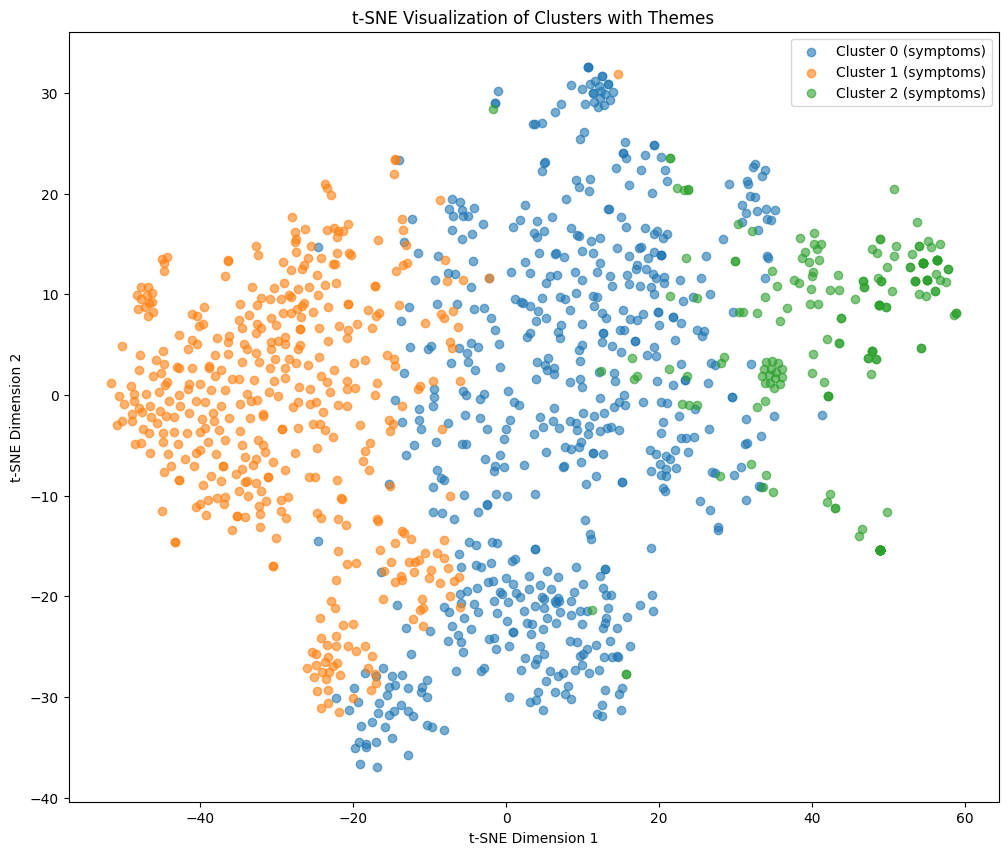

In [17]:
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.manifold import TSNE
import pandas as pd

# Define sepsis-related keywords grouped by categories
sepsis_keywords = {
    'symptoms': ['fever', 'tachycardia', 'hypotension', 'leukocytosis', 'respiratory distress'],
    'diagnosis': ['sepsis', 'septic', 'bacteremia', 'blood culture', 'inflammatory response', 'systemic'],
    'treatment': ['antibiotics', 'shock', 'organ failure', 'multi-organ failure']
}

def analyze_cluster_themes(df, num_clusters, sepsis_keywords):
    """
    Analyze the themes of each cluster based on the frequency of sepsis-related keywords.
    """
    cluster_themes = {}

    for cluster_id in range(num_clusters):
        cluster_texts = df[df['cluster'] == cluster_id]['processed_text'].tolist()
        word_counter = Counter(' '.join(cluster_texts).split())

        theme_counts = {theme: sum(word_counter[keyword] for keyword in keywords) for theme, keywords in sepsis_keywords.items()}
        cluster_themes[cluster_id] = theme_counts

    return cluster_themes

def plot_clusters_tsne_with_themes(X, clusters, num_clusters, cluster_themes):
    """
    Plot the clusters using t-SNE for dimensionality reduction, with themes annotated.
    """
    try:
        # Apply t-SNE for dimensionality reduction
        tsne = TSNE(n_components=2, perplexity=40, random_state=42)
        X_tsne = tsne.fit_transform(X)

        # Create a DataFrame for t-SNE results
        tsne_df = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
        tsne_df['cluster'] = clusters

        # Determine the dominant theme for each cluster
        dominant_themes = {cluster_id: max(themes, key=themes.get) for cluster_id, themes in cluster_themes.items()}

        # Plot the t-SNE results with themes
        plt.figure(figsize=(12, 10))
        for cluster_id in range(num_clusters):
            cluster_data = tsne_df[tsne_df['cluster'] == cluster_id]
            plt.scatter(cluster_data['tsne1'], cluster_data['tsne2'], label=f'Cluster {cluster_id} ({dominant_themes[cluster_id]})', alpha=0.6)
        
        plt.xlabel("t-SNE Dimension 1")
        plt.ylabel("t-SNE Dimension 2")
        plt.title("t-SNE Visualization of Clusters with Themes")
        plt.legend()
        plt.show()

        logging.info("t-SNE cluster plot with themes generated successfully.")

    except Exception as e:
        logging.error(f"Error during t-SNE plotting with themes: {e}")
        raise

# Analyze the themes of each cluster
num_clusters = 3
cluster_themes = analyze_cluster_themes(train_df, num_clusters, sepsis_keywords)

# Display the analysis results
for cluster_id, themes in cluster_themes.items():
    print(f"\nCluster {cluster_id} Theme Analysis:")
    print(themes)

# Plot the clusters using t-SNE with themes annotated
plot_clusters_tsne_with_themes(X_train, train_df['cluster'], num_clusters, cluster_themes)
